# Classification of academic paper titles

*Tanjin He, SeungHugh Jeong*

## Abstract

Only given a title of an academic paper, can we predict which journal in a list of candidates is the most possible one to accept it?
Data-driven methods without domain knowledge were utilized to address this problem in this work.
In this study, four academic journals were selected to conduct text classification for the paper titles. 
Through selecting the words and phrases with large weight in a trained logistic regression model, an effective classification model was constructed.
Sentence embedding from sent2vec were also explored to take advantage of unsupervised learned knowledges. 
Both approaches achieve accuracy over 80% for all the test sets, even for similar journal from the same domain.
This study may help fresh researchers to quickly find the best matched journal without manually reading introduction and paper samples for all the journals.

## Introduction

Fresh researchers often get a problem after completing their research work: which journal should they submit their paper to? 
Considering the title is the most compressed data which can reflect what has been done in a paper and also for simplification, we rephrase the question as "Only given a title of an academic paper, can we predict which journal in a list of candidates is the most possible one to accept it?"

This question could be answered using data-driven methods without domain experts.
There are many academic papers published on the internet and the corresponding paper titles and journal names are visible to everyone. 
We can define each journal as a set of all the historical papers published on that journal.
For a new paper, by analyzing its similarity to all the journal candicates, it might be assumed that the most similar journal would accept this new paper with the largest probability.

In this study, for illutration, we selected four journals and trained machine learning models to classify which is the most probable one to accept a given paper title.
First, we collected titles of paperd published on these journals since 2000. 
Then we conducted exploratory data analysis (EDA) to find the potential features for classification.
Inspird by the EDA process, we utilized sent2vec [1] to convert each title to a sentence embedding vector for classification.
At last, logistic regression and random forest were doped along with the sentences embeddings to build a classifer for paper titles.
This study may help fresh researchers to quickly find the best matched journal without manually reading introduction and paper samples for all the journals.


## Data

Most paper titles are available on the website of the well-known publishers such as Elsevier, Springer, Wiley, etc.
However, the amount of data could be huge since there are so many papers from all different academic fields. 
It is hard to make a comprehensive study on all the papers in terms of the computational capability. 
In this study, two sets of selected journals were used for simplification.

*Set A*: A journal from physics field, *Physica B: Condensed Matter*, and a journal from chemistry field, *Organic and Biomolecular Chemistry*, were selected as a stratified sampling process. 
This sample will help to identify the difference between journals from two different domains.


*Set B*: The materials field was chosen and then two journal from materials field, *Materials Science and Engineering: A* and *materials letters* were selected as multi-stage sampling process. 
This sample will help to identify the different between journals in the same domain.


Webscraping was used to collect the webpages corresponding to papers in the four journals in *Set A* and *Set B*. 
BeautifulSoup was used to parse the HTML data and extract the data from title field in the HTML pages.
There are many titles not meaningful for this study, such as "Preface" and "Publisher's Note". 
Therefore, too short titles (less than 30 characters) and duplicated titles were removed to get cleaner data.
At last, 19862 titles from *Physica B: Condensed Matter*, 12150 from *Organic and Biomolecular Chemistry*,  21953 titles from *Materials Science and Engineering: A*, and   21626 *materials letters* were collected and used in this study.

##### Load data

In [17]:
import pandas as pd
from IPython.display import display
import os
import json
import re
import random
import numpy as np
import shutil
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
from time import time

from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phrases, Phraser
from MulticoreTSNE import MulticoreTSNE 
import sent2vec
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline


In [3]:
data_set_A = pd.read_csv('rsc/titles_bio_condense_2.csv')
data_set_B = pd.read_csv('rsc/titles_materials_top2.csv')
journals_A = data_set_A['journal_lowercase'].unique()
journals_B = data_set_B['journal_lowercase'].unique()
data_set_A['label'] = data_set_A['journal_lowercase'] == journals_A[0]
data_set_A['label'] = data_set_A['label'].astype(int)
data_set_B['label'] = data_set_B['journal_lowercase'] == journals_B[0]
data_set_B['label'] = data_set_B['label'].astype(int)
print('data_set_A.shape', data_set_A.shape)
display(data_set_A.head())
print('data_set_B.shape', data_set_B.shape)
display(data_set_B.head())

data_set_A.shape (32012, 3)


,true_title,journal_lowercase,label
0,Stable ion study of benzo[a]pyrene (BaP) deriv...,organic & biomolecular chemistry,1
1,Effect of sintering conditions on the microstr...,physica b: condensed matter,0
2,Correction: β-Amyrin synthase from Euphorbia t...,organic & biomolecular chemistry,1
3,β-Amyrin synthase from Euphorbia tirucalli L. ...,organic & biomolecular chemistry,1
4,The use of enantiomerically pure ketene dithio...,organic & biomolecular chemistry,1


data_set_B.shape (43579, 3)


,true_title,journal_lowercase,label
0,Discussion on ‘influence of applied electric f...,materials science and engineering: a,1
1,Critique on the “Crystallinity and selected pr...,materials science and engineering: a,1
2,Effects of short-time heat treatment and subse...,materials science and engineering: a,1
3,Preparation of plate-like copper nitride nanop...,materials letters,0
4,"Coupled modeling of electromagnetic field, flu...",materials science and engineering: a,1


## Methods

Firstly, EDA was conducted to inspire the feature designing. 
It is found that words and phrases are the most effective features. 
To selecte the words and phrases most effective in the classification, all the words and the common bi-gram phrases were collected as initial candidates.
Logistic regression was utilized on the initial candidates to obtain the words and phrases with the most significant fitted weights, which indicates these words and phrases are the most useful features. The initial phrases were collected using gensim [2].

To be more generic and automatic, an unsupervised method based on compositional uni- and bi-grams, sent2vec [1] were adoped to convert a sentence to embeddings. 
Similar to the EDA process, the sentence embeddings are taking advantage of the the bag of words and phrases by averaging the vector for each word and phrase.
However, different from picking up the words/phrases with the largest weights in the EDA, the sentence embeddings use all the words and bi-grams, in which the manual feature engineering is avoided.

Both feature vectors from EDA and sent2vec were used in logistic regression and random forest for classification.

## Results and Discussion

### EDA

##### Some utility functions first

In [21]:
# function for data spliting
def data_split(input_data, val_frac=0.1, test_frac=0.1):
    data_copy = input_data.sample(frac=1).reset_index(drop=True)
    train = data_copy.iloc[:int(len(input_data)*(1-val_frac-test_frac)), :]
    val = data_copy.iloc[int(len(input_data)*(1-val_frac-test_frac)):int(len(input_data)*(1-test_frac)), :]
    test = data_copy.iloc[int(len(input_data)*(1-test_frac)): ,:]
    print('data_copy.shape', data_copy.shape)
    print('train.shape', train.shape)
    print('val.shape', val.shape)
    print('test.shape', test.shape)
    return train, val, test

def data_evaluation(Y_predict, Y_true):
    confusion_matrix = pd.DataFrame({'Y_predict': Y_predict, 'Y_true': Y_true } )
    confusion_matrix['TF'] = confusion_matrix.apply(lambda x: 'T' if x.Y_true==x.Y_predict else 'F', axis=1)
    confusion_matrix['PN'] = confusion_matrix['Y_predict'].apply(lambda x: 'P' if x==1 else 'N')
    TP = len(confusion_matrix[(confusion_matrix['TF']=='T')&(confusion_matrix['PN']=='P')])
    FP = len(confusion_matrix[(confusion_matrix['TF']=='F')&(confusion_matrix['PN']=='P')])
    TN = len(confusion_matrix[(confusion_matrix['TF']=='T')&(confusion_matrix['PN']=='N')])
    FN = len(confusion_matrix[(confusion_matrix['TF']=='F')&(confusion_matrix['PN']=='N')])
    precision_P = (TP)/max((TP+FP), 1)
    recall_P = TP/max((TP+FN), 1)
    precision_N = (TN)/max((TN+FN), 1)
    recall_N = TN/max((TN+FP), 1)  
    accuracy = (TP+TN)/max((TP+FP+TN+FN), 1)
    return {
        'precision_P': precision_P,
        'recall_P': recall_P,
        'precision_N': precision_N,
        'recall_N': recall_N,
        'accuracy': accuracy,
    }


def create_new_label(journal, journal_list):
    return journal_list.index(journal)

def get_words(data):
    df = data.copy()
    df.fillna('', inplace = True)
    journals = df['journal_lowercase'].unique()
    
    preposition_words = ["of", "Of", "in", "In", "and", "And", 
                         "the", "The", "at", "At", "from", "From", 
                         "On", "on", 'a', "by", "By", "for", "For", "at", "At", 'A',
                         "to", "To", "an", "An", "With", "with", "As", "as"]
#     count number of papers for each word
    chem, phys = dict(), dict()
    for title in df[df['journal_lowercase']==journals[0]]['true_title']:
#       TODO:  we might want to use spacy tokenizer later
        for word in set(title.split()):
            if word not in preposition_words:
                chem[word] = chem.get(word, 0) + 1
    for title in df[df['journal_lowercase']==journals[1]]['true_title']:
        for word in set(title.split()):
            if word not in preposition_words:
                phys[word] = phys.get(word, 0) + 1

    chem_df = pd.DataFrame(chem.items(), columns = ["word", "num_paper_" + journals[0]])
    phys_df = pd.DataFrame(phys.items(), columns = ["word", "num_paper_" + journals[1]])
    joined_df = chem_df.join(phys_df.set_index("word"), on = "word")
    joined_df.fillna(0, inplace = True)

    joined_df.loc[:, "proportion_"+journals[0]] = joined_df.loc[:, "num_paper_" + journals[0]] / len(df[df['journal_lowercase']==journals[0]])
    joined_df.loc[:, "proportion_"+journals[1]] = joined_df.loc[:, "num_paper_" + journals[1]] / len(df[df['journal_lowercase']==journals[1]])
    joined_df['average_proportion'] = (joined_df.loc[:, "proportion_"+journals[0]] \
                                       + joined_df.loc[:, "proportion_"+journals[1]])/2.0
    joined_df['proportion_difference'] = np.abs(
        joined_df.loc[:, "proportion_"+journals[0]] \
        - joined_df.loc[:, "proportion_"+journals[1]]
    )
    
    return joined_df


def get_phrases(data, min_cnt = 3, thrshld = 10):
    # min_count (float, optional) – Ignore all words and bigrams with total collected count lower than this value.
    # threshold (float, optional) – Represent a score threshold for forming the phrases (higher means fewer phrases). A phrase of words a followed by b is accepted if the score of the phrase is greater than threshold. Heavily depends on concrete scoring-function, see the scoring parameter.
    
    df = data.copy()
    df.fillna('', inplace = True)
    journals = df['journal_lowercase'].unique()

    tokenized_chem = [title.split() for title in df[df['journal_lowercase']==journals[0]]['true_title']]
    tokenized_phys = [title.split() for title in df[df['journal_lowercase']==journals[1]]['true_title']]

    chem_phrases = Phrases(tokenized_chem, min_count = min_cnt, threshold = thrshld)
    phys_phrases = Phrases(tokenized_phys, min_count = min_cnt, threshold = thrshld)
    
    phys, chem = dict(), dict()
    for title in df[df['journal_lowercase']==journals[0]]['true_title']:
#       TODO:  we might want to use spacy tokenizer later
        for phrase, score in chem_phrases.export_phrases([title.split()]):
            phrase = phrase.decode('utf-8')
            chem[phrase] = chem.get(phrase, 0) + 1

    for title in df[df['journal_lowercase']==journals[1]]['true_title']:
        for phrase, score in phys_phrases.export_phrases([title.split()]):
            phrase = phrase.decode('utf-8')
            phys[phrase] = phys.get(phrase, 0) + 1

    chem_df = pd.DataFrame(chem.items(), columns = ["phrase", "num_paper_" + journals[0]])
    phys_df = pd.DataFrame(phys.items(), columns = ["phrase", "num_paper_" + journals[1]])
    joined_df = chem_df.join(phys_df.set_index("phrase"), on = "phrase")
    joined_df.fillna(0, inplace = True)
    
    joined_df.loc[:, "proportion_"+journals[0]] = joined_df.loc[:, "num_paper_" + journals[0]] / len(df[df['journal_lowercase']==journals[0]])
    joined_df.loc[:, "proportion_"+journals[1]] = joined_df.loc[:, "num_paper_" + journals[1]] / len(df[df['journal_lowercase']==journals[1]])
    joined_df['average_proportion'] = (joined_df.loc[:, "proportion_"+journals[0]] \
                                       + joined_df.loc[:, "proportion_"+journals[1]])/2.0
    joined_df['proportion_difference'] = np.abs(
        joined_df.loc[:, "proportion_"+journals[0]] \
        - joined_df.loc[:, "proportion_"+journals[1]]
    )
    
    return joined_df


def phrases_in_texts(phrases, texts):
    '''
    Args:
        phrases (list-like): phrases to find
        texts (Series): strings to search in

    Returns:
        Numpy array of 0s and 1s with shape (n, p) where n is number of texts and p is number of phrases
    '''
    contain_phrases = [texts.str.contains(phrase, regex=False).astype(int) for phrase in phrases]
    indicator_array = np.array(contain_phrases).T
    return indicator_array

def data_process(input_data, feature_words_phrases):
    X =  phrases_in_texts(feature_words_phrases, input_data.loc[:, 'true_title'])
    Y = input_data['label']
    return X, Y


def plot_proportion(wp, words_count, phrases_count, journals):
    text_count = pd.concat([
            words_count.rename(columns={'word': 'text'}), 
            phrases_count.rename(columns={'phrase': 'text'}),
        ])
    text_count = text_count[text_count['text'].isin(wp)]
    wp_df = pd.DataFrame()
    for jour in journals:
        column_name = 'proportion_' + jour
        tmp_df = text_count[['text', column_name]]
        tmp_df = tmp_df.rename(columns={column_name: 'proportion'})
        tmp_df['journal_lowercase'] = jour
        wp_df = wp_df.append(tmp_df)
    
    # plot
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    sns.barplot(x='text', y='proportion', hue='journal_lowercase', data=wp_df, ci=None)
    plt.title('Proportion of usage in different journals', 
              size=26, y=1.03)
    plt.xlabel('Words/Phrases', size=22)
    plt.ylabel('Percentage of papers', size=22)
    ax.tick_params(axis='both', which='major', labelsize=18)
    legend_1 = plt.legend(loc='best', fontsize=22)
    legend_1.set_title('')
    plt.ylim(0, max(wp_df['proportion'])*1.5)
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
    
    
def plot_TSNE(data, embeddings):
    n_components = 2
    perplexity = 50

    journal_names = data['journal_lowercase'].unique()
    data_sample = data
#     data['embeddings'] = pd.Series(tuple(embeddings))
#     data_sample = data.sample(frac=0.01).reset_index(drop=True)
#     embeddings = np.array(list(data_sample['embeddings']))

    red = data_sample['journal_lowercase'] == journal_names[0]
    green = data_sample['journal_lowercase'] == journal_names[1]

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    t0 = time()
    tsne = MulticoreTSNE(n_components=n_components, perplexity=perplexity, n_jobs=4, metric='cosine')
    Y = tsne.fit_transform(embeddings)
    t1 = time()
    print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("2D projection by TSNE", fontsize=22)
    ax.scatter(Y[red, 0], Y[red, 1], facecolors='none', edgecolors='r', label=journal_names[0])
    ax.scatter(Y[green, 0], Y[green, 1], facecolors='none', edgecolors='g', label=journal_names[1])
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    legend_1 = plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=18)

##### Data splitting

Randomly split data into train, evaluation, and test sets with ratio=8:1:1.

In [5]:
# data spliting
val_frac = 0.1
test_frac = 0.1
train_A, val_A, test_A = data_split(data_set_A, val_frac, test_frac)
train_B, val_B, test_B = data_split(data_set_B, val_frac, test_frac)

data_copy.shape (32012, 3)
train.shape (25609, 3)
val.shape (3201, 3)
test.shape (3202, 3)
data_copy.shape (43579, 3)
train.shape (34863, 3)
val.shape (4358, 3)
test.shape (4358, 3)


##### Get words and phrases
Get all the words.
Get all the phrases using gensim [2].

In [6]:
words_A = get_words(train_A)
print('words_A.shape', words_A.shape)
display(words_A.head())

phrases_A = get_phrases(train_A, min_cnt = 3, thrshld = 1)
print('phrases_A.shape', phrases_A.shape)
display(phrases_A.head())

words_B = get_words(train_B)
print('words_B.shape', words_B.shape)
display(words_B.head())

phrases_B = get_phrases(train_B, min_cnt = 3, thrshld = 1)
print('phrases_B.shape', phrases_B.shape)
display(phrases_B.head())


words_A.shape (24514, 7)


,word,num_paper_organic & biomolecular chemistry,num_paper_physica b: condensed matter,proportion_organic & biomolecular chemistry,proportion_physica b: condensed matter,average_proportion,proportion_difference
0,optimization,17,18.0,0.001746,0.001134,0.001440,0.000612
1,phenylacetonitrile,1,0.0,0.000103,0.000000,0.000051,0.000103
2,condensation,26,28.0,0.002670,0.001764,0.002217,0.000906
3,mechanistic,56,0.0,0.005751,0.000000,0.002875,0.005751
4,nonanenitrile,1,0.0,0.000103,0.000000,0.000051,0.000103


phrases_A.shape (2550, 7)


,phrase,num_paper_organic & biomolecular chemistry,num_paper_physica b: condensed matter,proportion_organic & biomolecular chemistry,proportion_physica b: condensed matter,average_proportion,proportion_difference
0,condensation of,8,5.0,0.000822,0.000315,0.000568,0.000506
1,and mechanistic,9,0.0,0.000924,0.000000,0.000462,0.000924
2,coupling of,44,0.0,0.004518,0.000000,0.002259,0.004518
3,acids to,10,0.0,0.001027,0.000000,0.000513,0.001027
4,Synthesis of,631,19.0,0.064798,0.001197,0.032997,0.063601


words_B.shape (24099, 7)


,word,num_paper_materials letters,num_paper_materials science and engineering: a,proportion_materials letters,proportion_materials science and engineering: a,average_proportion,proportion_difference
0,Preparation,906,106.0,0.052803,0.005987,0.029395,0.046816
1,hydrogels,36,0.0,0.002098,0.000000,0.001049,0.002098
2,properties,2527,3390.0,0.147278,0.191471,0.169375,0.044193
3,nanoparticles,1106,78.0,0.064460,0.004406,0.034433,0.060054
4,reinforced,121,449.0,0.007052,0.025360,0.016206,0.018308


phrases_B.shape (4460, 7)


,phrase,num_paper_materials letters,num_paper_materials science and engineering: a,proportion_materials letters,proportion_materials science and engineering: a,average_proportion,proportion_difference
0,Preparation and,427,59.0,0.024886,0.003332,0.014109,0.021554
1,mechanical properties,143,1083.0,0.008334,0.061169,0.034752,0.052835
2,silica nanoparticles,9,0.0,0.000525,0.000000,0.000262,0.000525
3,composite hydrogels,5,0.0,0.000291,0.000000,0.000146,0.000291
4,Crystallization behavior,7,10.0,0.000408,0.000565,0.000486,0.000157


##### Words and phrases selection
Use words and phrases to do classification with logistic regression with L1 regularization.
Pick up the top 3% with largest magnitude of weights.

In [7]:
def get_top_wp(data, all_wp, fraction=0.03, wp_batches = 50):
    top_wp = []
    
    all_wp = all_wp.copy()
    random.shuffle(all_wp)
    wp_batches_size = int(len(all_wp)/wp_batches)
    for i in range(wp_batches):
        if i < wp_batches - 1:
            test_wp = all_wp[i*wp_batches_size:(i+1)*wp_batches_size]
        else:
            test_wp = all_wp[i*wp_batches_size:]
        X, Y = data_process(data, test_wp)
        model_df = LogisticRegression(penalty = 'l1').fit(X, Y)
        weights = np.abs(model_df.coef_[0])
        thrshld = sorted(weights, reverse=True)[int(fraction*len(weights))]
        selected_index = weights > thrshld
        top_wp.extend(list(pd.Series(test_wp)[selected_index]))
    return top_wp


In [8]:
all_wp_A = list(words_A['word']) + list(phrases_A['phrase'])
feature_wp_A = get_top_wp(train_A, all_wp_A)
print('feature_wp_A', feature_wp_A)

feature_wp_A ['6-', '1,3-dipolar', 'selective synthesis', 'dipeptide', 'toxicity', 'a mechanistic', 'macrocyclic', 'ordering', 'substituent', 'Palladium-catalyzed', 'Stereoselective', 'mediated', 'oxindole', 'catalysis:', 'analogs', 'living cells', 'glycopeptide', 'One-pot synthesis', 'biomimetic', 'kinase', '2′,', 'three-component reaction', 'amphiphile', 'conjugate', 'benzothiazole', 'polyketide', 'chromophores', 'cascade reaction', 'enantiomer', 'photophysical properties', 'of carbonyl', 'amides with', 'highly functionalized', 'catalyzed asymmetric', 'rearrangement of', 'cyclisation of', 'annulation', 'polyhydroxy', 'aziridines', 'concise', 'reductive', 'pyrrolidines', 'alkylation of', 'alkylidene', 'rotaxanes', 'building', 'evaluation of', 'glass', 'cyclopropane', 'diones', 'α-amino acids', 'transferase', 'Mechanistic', 'cyclic', 'pathway', 'Asymmetric synthesis', 'of aromatic', 'toward', 'in water', 'select', 'lone', 'ligation', 'agent', 'supramolecular', 'reactions', '2-amino', '

In [9]:
all_wp_B = list(words_B['word']) + list(phrases_B['phrase'])
feature_wp_B = get_top_wp(train_B, all_wp_B)
print('feature_wp_B', feature_wp_B)

feature_wp_B ['solar cell', 'Electrospinning', 'acid)', 'gel method', 'CoO', 'sphere', 'electromagnetic absorption', 'drying', 'superhydrophobic', 'capacitive', 'beam evaporation', 'arrays as', '(Ba,', 'synthesis', 'nanoparticle', 'for sodium', 'CuI', 'fluorine', 'ZIF-8', 'supercapacitors', 'delivery', 'assembled', 'nanowires by', 'Optical', 'photocatalysts', 'sensing properties', 'as-extruded', 'ferroic', 'microstructural evolution', 'electric properties', 'nanorod arrays', 'Li4Ti5O12', 'nanorods', 'frameworks', 'embrittlement', 'photocatalytic performance', 'Co3O4', 'red phosphor', 'detection', 'dyes', 'violet', 'solvents', 'of hierarchical', 'One-step synthesis', 'microrods', 'chains', 'from single', 'supported', 'green synthesis', 'photocatalytic degradation', 'ZnO nanorod', 'grown on', 'brush', 'femtosecond', 'lithium-ion batteries', 'microflowers', 'ethylene glycol', 'CuInSe2', 'for dye', 'of mesoporous', 'photo', 'hematite', 'sodium', 'tellurite', 'polyarylene ether', 'phosphori

##### Plot frequency of using selected words and phrases in two journals
For visualization, pick 20 of the words and phrases with largest weights in logistic regression and plot the proportion of papers which uses the words/phrases in each journal.

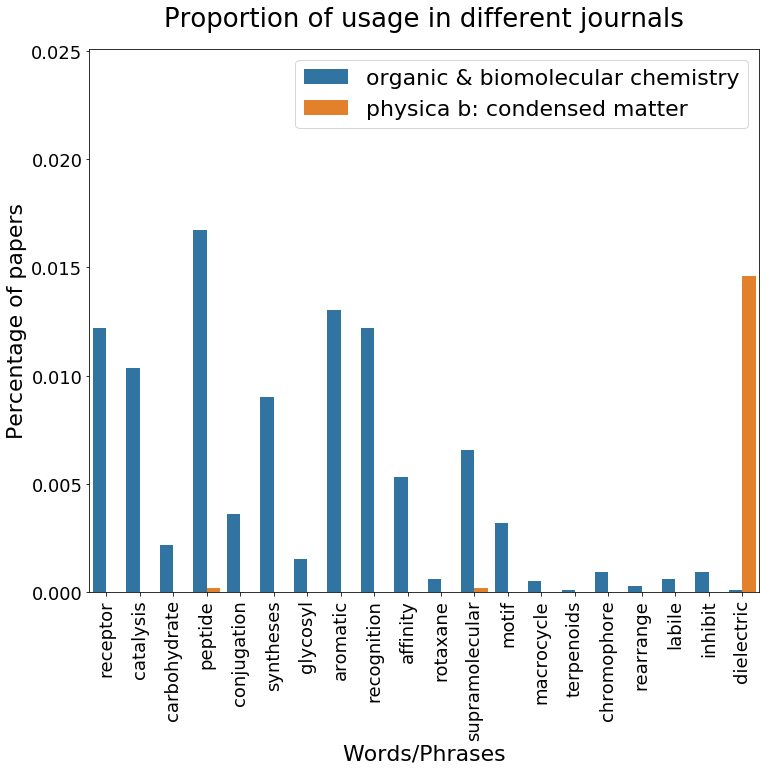

In [10]:
feature_to_plot_A = get_top_wp(train_A, feature_wp_A, fraction=0.03, wp_batches = 1)
plot_proportion(feature_to_plot_A[:20], words_A, phrases_A, journals_A)

*Fig. 1. Proportion of usage of 20 most effective words/phrases for logistic regression in data set A*

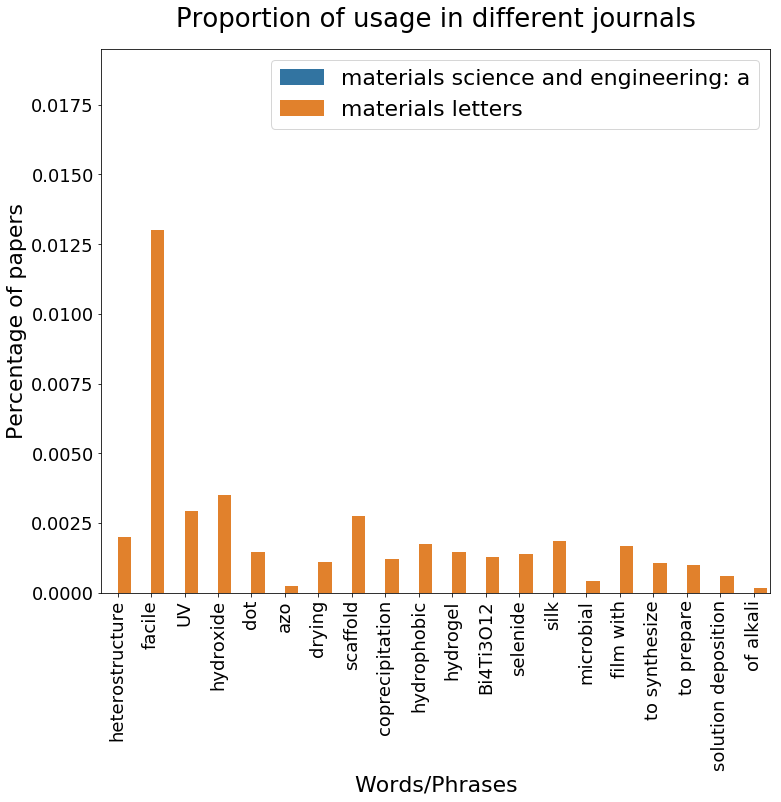

In [11]:
feature_to_plot_B = get_top_wp(train_B, feature_wp_B, fraction=0.03, wp_batches = 1)
plot_proportion(feature_to_plot_B[:20], words_B, phrases_B, journals_B)

*Fig. 2. Proportion of usage of 20 most effective words/phrases for logistic regression in data set B*

The 20 words/phrases plot in Fig. 1 and Fig. 2 are the ones with the largest magnitude of weights in logistic regression.
From Fig. 1 and Fig. 2, we can find that the magnitude of difference in proportion of usage is generally larger for the two journals in data set A comparing with data set B.
Namely, for data set B, the propotion of some words/phrases are close to zero in two journals.
This observation indicates that the titles in the two journals in data set B are more similar comparing with data set A. 
Namely, the classification is more difficult for data set B than data set A.
It makes sense because the two journals in data set A are from two different research fields, while the two journals in data set B are both from materials field.

##### 2D projection of featured words and phrases
With t-Distributed Stochastic Neighbor Embedding (t-SNE), which is a nonlinear dimensionality reduction technique high-dimensional data, it is possible to project the features vector specified by the words and phrases onto a 2d plane for visualization.

In [12]:
train_X_wp_A, train_Y_A = data_process(train_A, feature_wp_A)
print('train_X_wp_A.shape', train_X_wp_A.shape)

train_X_wp_A.shape (25609, 800)


circles, perplexity=50 in 2.4e+02 sec


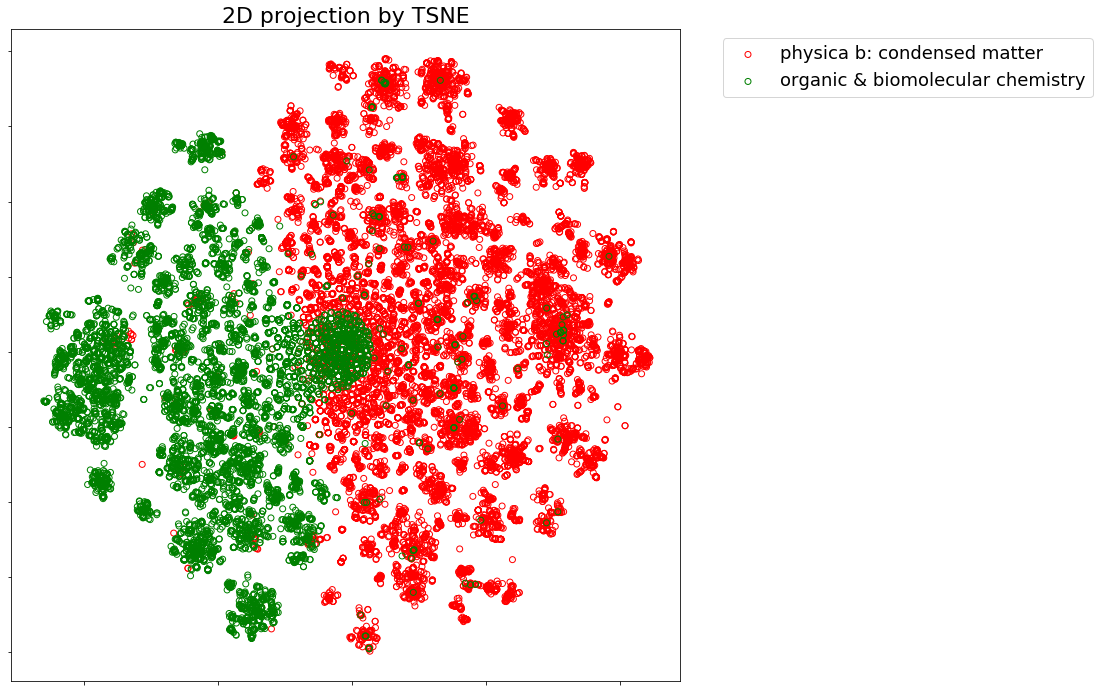

In [59]:
plot_TSNE(train_A, train_X_wp_A)

In [13]:
train_X_wp_B, train_Y_B = data_process(train_B, feature_wp_B)
print('train_X_wp_B.shape', train_X_wp_B.shape)


train_X_wp_B.shape (34863, 850)


circles, perplexity=50 in 3.5e+02 sec


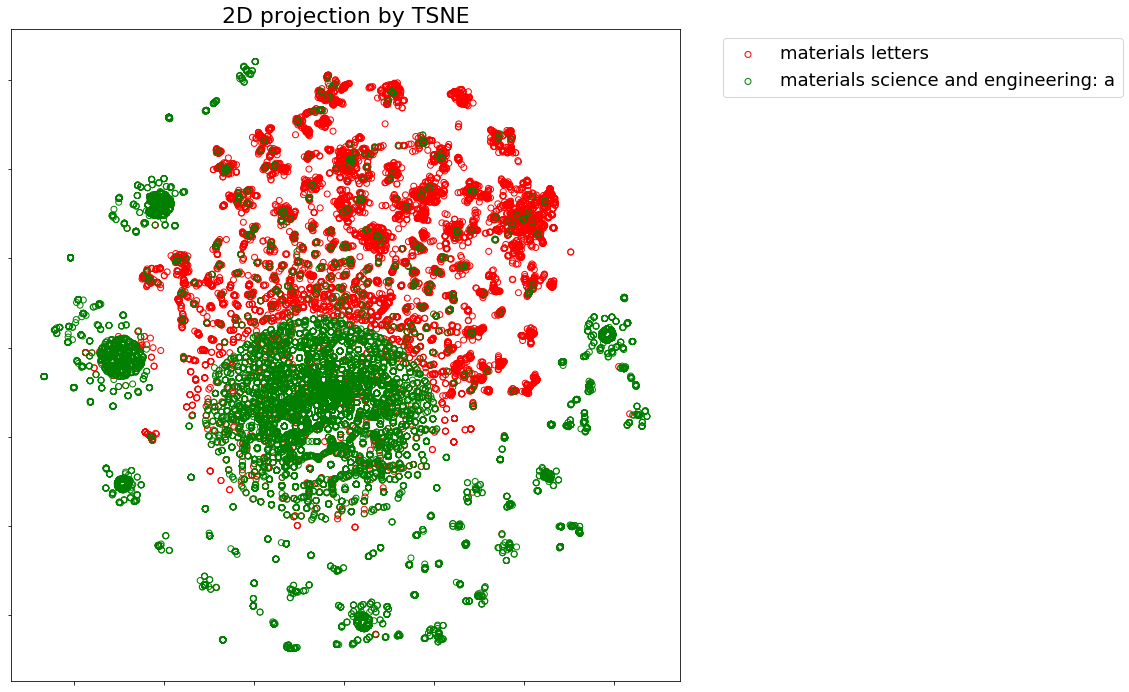

In [61]:
plot_TSNE(train_B, train_X_wp_B)

Again, we can see that the data are separated better for data set A than for data set B.

##### Get sentence embeddings
As introduced in the Method section, sent2vec was used to obtain sentence embeddings, which could take more words/phrases information into the feature vector.

In [14]:
send2vec_model = sent2vec.Sent2vecModel()
send2vec_model.load_model(os.path.join('/docker_exchange/sent2vec/models/', 'torontobooks_bigrams.bin'))

In [15]:
def get_sent_embeddings(data, model):
    print('data.shape', data.shape)
    all_embeddings = []
    input_data = data
    batch_size = 1000
    for i in range(0, int(len(input_data)/batch_size)+1):
        batch_data = input_data.iloc[i*batch_size: (i+1)*batch_size, :].copy()
        if len(batch_data) == 0:
            continue
        batch_data = batch_data.reset_index(drop=True)
        sent_embeddings = model.embed_sentences(batch_data['true_title'])
        all_embeddings.extend(sent_embeddings) 
    all_embeddings = np.array(all_embeddings)
    print('all_embeddings.shape', all_embeddings.shape)
    return all_embeddings


In [16]:
train_embedding_A = get_sent_embeddings(train_A, send2vec_model)
train_embedding_B = get_sent_embeddings(train_B, send2vec_model)

data.shape (25609, 3)


all_embeddings.shape (25609, 700)
data.shape (34863, 3)


all_embeddings.shape (34863, 700)


##### 2D projection of sentence embeddings
Similarly, we can use t-SNE to get a feeling of the quality of sentence embeddings.

circles, perplexity=50 in 2.4e+02 sec


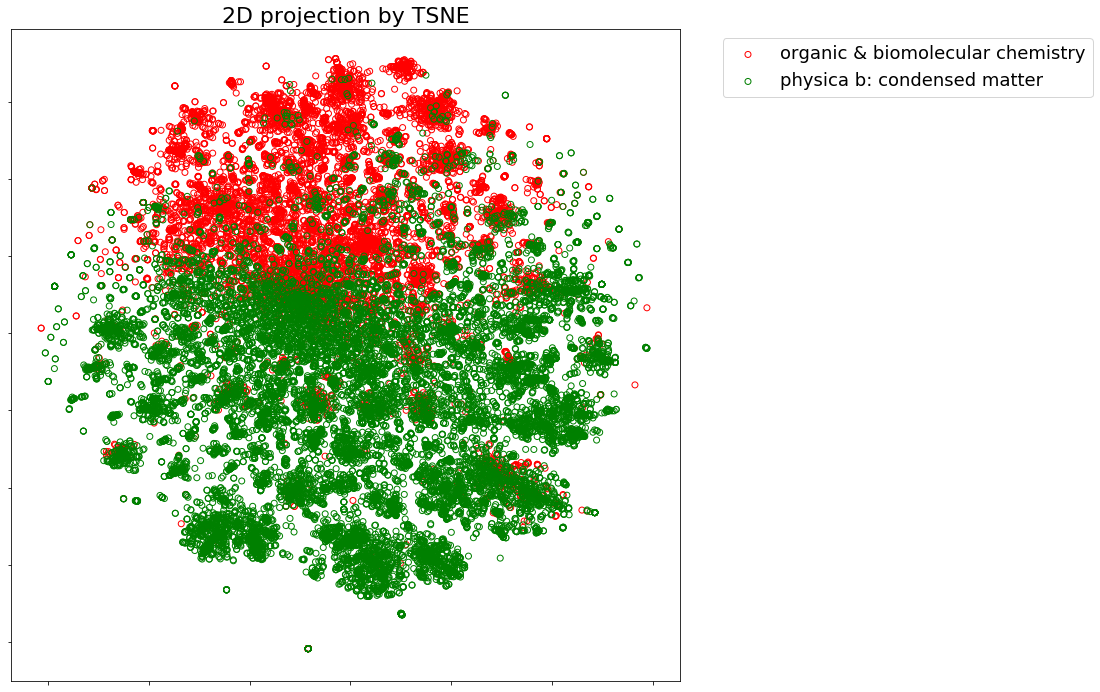

In [18]:
plot_TSNE(train_A, train_embedding_A)

It should be noticed that the sentence embeddings are absolutely from pre-trained knowledge. 
No supervised feature engineering is involved.
However, the t-SNE plot clearly proved that the sentence embeddings are potential for classification.

circles, perplexity=50 in 3.9e+02 sec


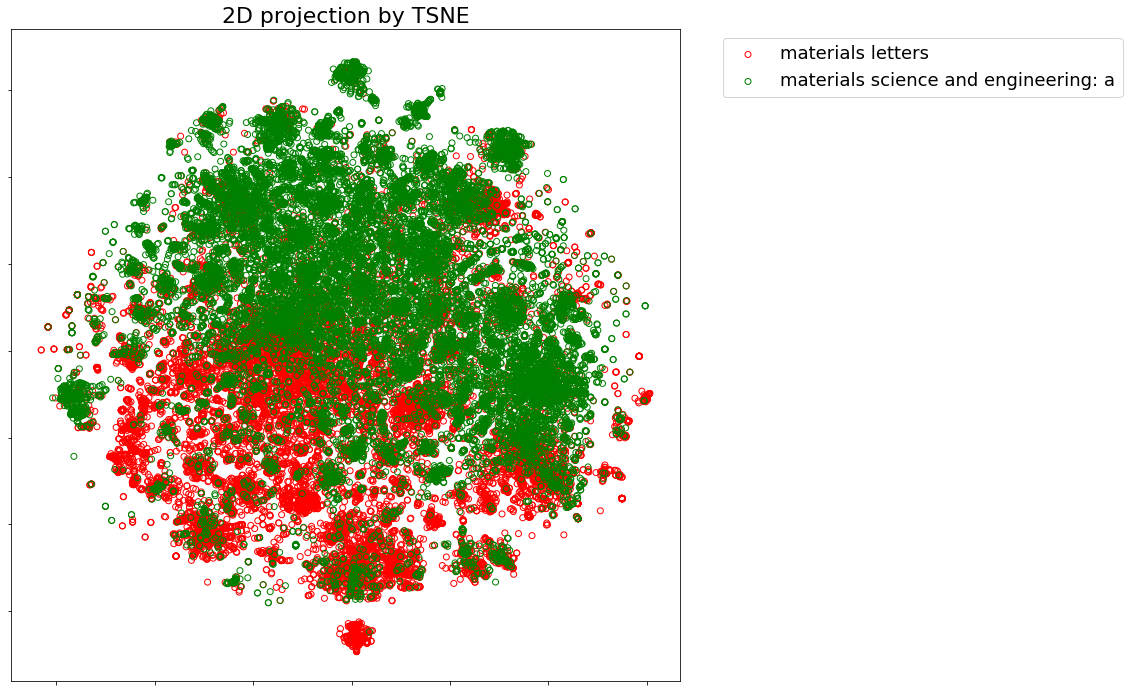

In [19]:
plot_TSNE(train_B, train_embedding_B)

### Classification 
Two types of features are used: (1) feature vectors of words and phrases, (2) sentence embeddings.

Two types of models are used: (a) logistic regression (b) random forest.

Model selection for best parameters are conducted for each combination.

In [0]:
def getAllParaCombo(paraMatrix):
    paraCombo = []
    firstKey = list(paraMatrix.keys())
    firstKey = firstKey[0]
    if len(paraMatrix) == 1:
        for tmp_para in paraMatrix[firstKey]:
            new_combo = {}
            new_combo[firstKey] = tmp_para
            paraCombo.append(new_combo)
    if len(paraMatrix) > 1:
        paraMatrixCopy = paraMatrix.copy()
        paraMatrixCopy.pop(firstKey)
        combos = getAllParaCombo(paraMatrixCopy)
        for tmp_para in paraMatrix[firstKey]:
            for tmp_combo in combos:
                new_combo = tmp_combo.copy()
                new_combo[firstKey] = tmp_para
                paraCombo.append(new_combo)
    return paraCombo

def removeParaCombo(paraCombo, paraTabu):
    paraCombo2 = paraCombo.copy()
    for tmp_papa_tabu in paraTabu:
        for tmp_para in paraCombo:
            if tmp_para not in paraCombo2:
                continue
            tmp_remove = True
            for tmp_key in tmp_papa_tabu:
                if tmp_key in tmp_para:
                    if tmp_para[tmp_key] != tmp_papa_tabu[tmp_key]:
                        tmp_remove = False
                else:
                    tmp_remove = False
            if tmp_remove == True:
                paraCombo2.remove(tmp_para)
    return paraCombo2


def model_selection(model, train_X, train_Y, val_X, val_Y, possible_params, para_tabu=[]):
    para_choices = getAllParaCombo(possible_params)
    para_choices = removeParaCombo(para_choices, para_tabu)
    best_acc = -1
    best_para = None
    for tmp_para in para_choices:
        model.set_params(**tmp_para)
        model.fit(train_X, train_Y)
        Y_pred = model.predict(val_X)
        acc = data_evaluation(Y_pred, val_Y)['accuracy']
        if acc > best_acc:
            best_para = tmp_para
            best_acc = acc
    return best_para, best_acc
        
    
def model_evaluation(model, params, train_X, train_Y, test_X, test_Y):
    model.set_params(**params)
    model.fit(train_X, train_Y)
    Y_pred = model.predict(test_X)
    result = data_evaluation(Y_pred, test_Y)
    return result

In [20]:
train_X_wp_A, train_Y_A = data_process(train_A, feature_wp_A)
val_X_wp_A, val_Y_A = data_process(val_A, feature_wp_A)
test_X_wp_A, test_Y_A = data_process(test_A, feature_wp_A)

train_embedding_A = get_sent_embeddings(train_A, send2vec_model)
val_embedding_A = get_sent_embeddings(val_A, send2vec_model)
test_embedding_A = get_sent_embeddings(test_A, send2vec_model)

train_X_wp_B, train_Y_B = data_process(train_B, feature_wp_B)
val_X_wp_B, val_Y_B = data_process(val_B, feature_wp_B)
test_X_wp_B, test_Y_B = data_process(test_B, feature_wp_B)

train_embedding_B = get_sent_embeddings(train_B, send2vec_model)
val_embedding_B = get_sent_embeddings(val_B, send2vec_model)
test_embedding_B = get_sent_embeddings(test_B, send2vec_model)

result_df = pd.DataFrame(columns=['data set', 'feature', 'model' 'accuracy'])

data.shape (25609, 3)


all_embeddings.shape (25609, 700)
data.shape (3201, 3)
all_embeddings.shape (3201, 700)
data.shape (3202, 3)
all_embeddings.shape (3202, 700)


data.shape (34863, 3)


all_embeddings.shape (34863, 700)
data.shape (4358, 3)
all_embeddings.shape (4358, 700)
data.shape (4358, 3)
all_embeddings.shape (4358, 700)


##### Classification with feature vectors of words and phrases and logistic regression

In [47]:
para_matrix = {}
para_matrix['C'] = [0.01, 0.1, 0.5, 1, 2, 5, 10, 100]
clf = LogisticRegression()
best_para, best_acc = model_selection(
    clf,  
    train_X_wp_A,
    train_Y_A,
    val_X_wp_A,
    val_Y_A,
    para_matrix,
)
result = model_evaluation(
    clf,
    best_para,
    train_X_wp_A,
    train_Y_A,
    test_X_wp_A,
    test_Y_A,
)
print('data set A', result)
result_df = result_df.append(
    {
        'data set': 'data set A', 
        'feature': 'selected words & phrases',
        'model': 'LogisticRegression',
        'accuracy': result['accuracy'],
    }, 
    ignore_index=True,
)

para_matrix = {}
para_matrix['C'] = [0.01, 0.1, 0.5, 1, 2, 5, 10, 100]
clf = LogisticRegression()
best_para, best_Bcc = model_selection(
    clf,  
    train_X_wp_B,
    train_Y_B,
    val_X_wp_B,
    val_Y_B,
    para_matrix,
)
result = model_evaluation(
    clf,
    best_para,
    train_X_wp_B,
    train_Y_B,
    test_X_wp_B,
    test_Y_B,
)
print('data set B', result)
result_df = result_df.append(
    {
        'data set': 'data set B', 
        'feature': 'selected words & phrases',
        'model': 'LogisticRegression',
        'accuracy': result['accuracy'],
    }, 
    ignore_index=True,
)

data set A {'precision_P': 0.9766031195840554, 'recall_P': 0.9399499582985822, 'precision_N': 0.96484375, 'recall_N': 0.9865202196704943, 'accuracy': 0.9690818238600875}


data set B {'precision_P': 0.7654698242933538, 'recall_P': 0.9430588235294117, 'precision_N': 0.9304597701149425, 'recall_N': 0.7250335871025526, 'accuracy': 0.8313446535107848}


##### Classification with sentence embeddings and logistic regression
Sentence embeddings are used as feature vector for comparison.

In [48]:
para_matrix = {}
para_matrix['C'] = [0.01, 0.1, 0.5, 1, 2, 5, 10, 100]
clf = LogisticRegression()
best_para, best_acc = model_selection(
    clf,  
    train_embedding_A,
    train_Y_A,
    val_embedding_A,
    val_Y_A,
    para_matrix,
)
result = model_evaluation(
    clf,
    best_para,
    train_embedding_A,
    train_Y_A,
    test_embedding_A,
    test_Y_A,
)
print('data set A', result)
result_df = result_df.append(
    {
        'data set': 'data set A', 
        'feature': 'sentence embeddings',
        'model': 'LogisticRegression',
        'accuracy': result['accuracy'],
    }, 
    ignore_index=True,
)

para_matrix = {}
para_matrix['C'] = [0.01, 0.1, 0.5, 1, 2, 5, 10, 100]
clf = LogisticRegression()
best_para, best_Bcc = model_selection(
    clf,  
    train_embedding_B,
    train_Y_B,
    val_embedding_B,
    val_Y_B,
    para_matrix,
)
result = model_evaluation(
    clf,
    best_para,
    train_embedding_B,
    train_Y_B,
    test_embedding_B,
    test_Y_B,
)
print('data set B', result)
result_df = result_df.append(
    {
        'data set': 'data set B', 
        'feature': 'sentence embeddings',
        'model': 'LogisticRegression',
        'accuracy': result['accuracy'],
    }, 
    ignore_index=True,
)

data set A {'precision_P': 0.9093988145639289, 'recall_P': 0.8957464553794829, 'precision_N': 0.938149430974765, 'recall_N': 0.946580129805292, 'accuracy': 0.9275452841973766}


data set B {'precision_P': 0.8006189213085765, 'recall_P': 0.8522352941176471, 'precision_N': 0.8501908396946565, 'recall_N': 0.7980295566502463, 'accuracy': 0.8244607618173474}


##### Classification with feature vectors of words and phrases and random forest

In [54]:
para_matrix = {}
para_matrix['n_estimators'] = [5, 10, 50, 100, 200, ]
para_matrix['max_depth'] = [5, 10, 50, 100]

clf = RandomForestClassifier()
best_para, best_acc = model_selection(
    clf,  
    train_X_wp_A,
    train_Y_A,
    val_X_wp_A,
    val_Y_A,
    para_matrix,
)
result = model_evaluation(
    clf,
    best_para,
    train_X_wp_A,
    train_Y_A,
    test_X_wp_A,
    test_Y_A,
)
print('data set A', result)
result_df = result_df.append(
    {
        'data set': 'data set A', 
        'feature': 'selected words & phrases',
        'model': 'RandomForest',
        'accuracy': result['accuracy'],
    }, 
    ignore_index=True,
)

para_matrix = {}
para_matrix['n_estimators'] = [5, 10, 50, 100, 200,]
para_matrix['max_depth'] = [5, 10, 50, 100]
clf = RandomForestClassifier()
best_para, best_Bcc = model_selection(
    clf,  
    train_X_wp_B,
    train_Y_B,
    val_X_wp_B,
    val_Y_B,
    para_matrix,
)
result = model_evaluation(
    clf,
    best_para,
    train_X_wp_B,
    train_Y_B,
    test_X_wp_B,
    test_Y_B,
)
print('data set B', result)
result_df = result_df.append(
    {
        'data set': 'data set B', 
        'feature': 'selected words & phrases',
        'model': 'RandomForest',
        'accuracy': result['accuracy'],
    }, 
    ignore_index=True,
)

data set A {'precision_P': 0.9686346863468634, 'recall_P': 0.8757297748123436, 'precision_N': 0.9296506137865911, 'recall_N': 0.9830254618072891, 'accuracy': 0.9428482198625859}


data set B {'precision_P': 0.7230714539637397, 'recall_P': 0.9571764705882353, 'precision_N': 0.9411003236245955, 'recall_N': 0.651141961486789, 'accuracy': 0.8003671408903167}


##### Classification with sentence embeddings and random forest

In [58]:
para_matrix = {}
para_matrix['n_estimators'] = [5, 10, 50, 100, 200, ]
para_matrix['max_depth'] = [5, 10, 50, 100, ]
clf = RandomForestClassifier()
best_para, best_acc = model_selection(
    clf,  
    train_embedding_A,
    train_Y_A,
    val_embedding_A,
    val_Y_A,
    para_matrix,
)
result = model_evaluation(
    clf,
    best_para,
    train_embedding_A,
    train_Y_A,
    test_embedding_A,
    test_Y_A,
)
print('data set A', result)
result_df = result_df.append(
    {
        'data set': 'data set A', 
        'feature': 'sentence embeddings',
        'model': 'RandomForest',
        'accuracy': result['accuracy'],
    }, 
    ignore_index=True,
)

para_matrix = {}
para_matrix['n_estimators'] = [5, 10, 50, 100, 200, ]
para_matrix['max_depth'] = [5, 10, 50, 100, ]
clf = RandomForestClassifier()
best_para, best_Bcc = model_selection(
    clf,  
    train_embedding_B,
    train_Y_B,
    val_embedding_B,
    val_Y_B,
    para_matrix,
)
result = model_evaluation(
    clf,
    best_para,
    train_embedding_B,
    train_Y_B,
    test_embedding_B,
    test_Y_B,
)
print('data set B', result)
result_df = result_df.append(
    {
        'data set': 'data set B', 
        'feature': 'sentence embeddings',
        'model': 'RandomForest',
        'accuracy': result['accuracy'],
    }, 
    ignore_index=True,
)

data set A {'precision_P': 0.9341004184100419, 'recall_P': 0.7447873227689742, 'precision_N': 0.8637577916295637, 'recall_N': 0.9685471792311533, 'accuracy': 0.8847595252966896}


data set B {'precision_P': 0.8010348071495766, 'recall_P': 0.8014117647058824, 'precision_N': 0.8109318996415771, 'recall_N': 0.8105687416032243, 'accuracy': 0.8061037173015144}


##### Plot results from different data sets, feature vectors, and models

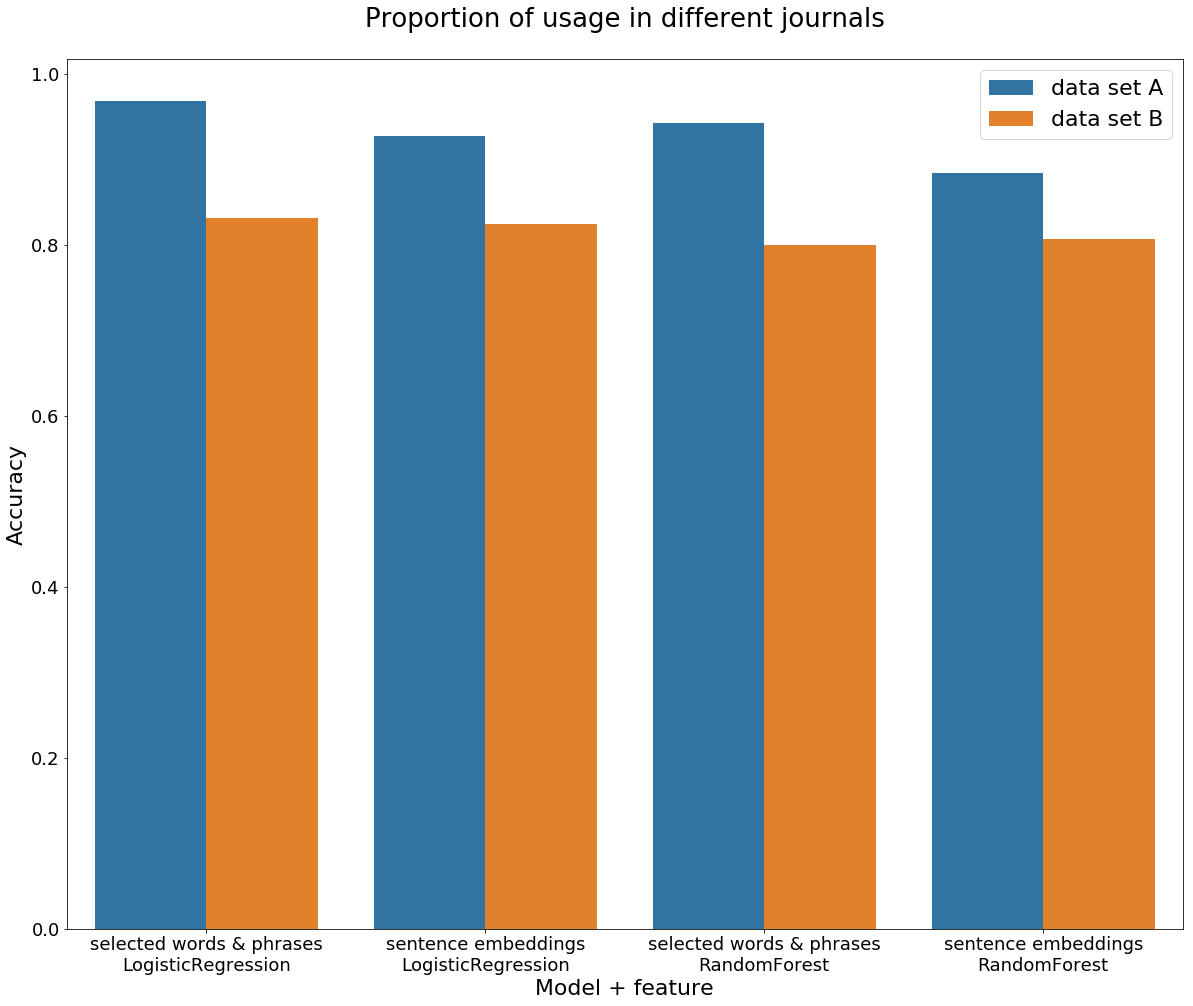

In [61]:
result_df['model_name'] = result_df.apply(
    lambda x: x.feature+'\n'+x.model, axis=1
)

# plot
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111)
sns.barplot(x='model_name', y='accuracy', hue='data set', data=result_df, ci=None)
plt.title('Proportion of usage in different journals', 
          size=26, y=1.03)
plt.xlabel('Model + feature', size=22)
plt.ylabel('Accuracy', size=22)
ax.tick_params(axis='both', which='major', labelsize=18)
legend_1 = plt.legend(loc='best', fontsize=22)
legend_1.set_title('')


## Summary

In this study, four academic journals were selected to conduct text classification for the paper titles. 
Through selecting the words and phrases with large weight in a trained logistic regression model, an effective feature vector was constructed.
Sentence embedding from sent2vec were also explored to take advantage of unsupervised learned knowledges. 
Both feature design works well with logistic regression and random forest classifiers.
Accuracy over 80% are achieve for all the test sets with all the models.
However, it is easier to classify paper titles from different domains than from the same domain.
More work need to be done to take advantange of the order of words, especially for long-range order.
New techniques, such as LSTM and transformers might be used for better classification result.


## Refence

[1] Matteo Pagliardini, Prakhar Gupta, Martin Jaggi, Unsupervised Learning of Sentence Embeddings using Compositional n-Gram Features NAACL 2018   
[2] Radim Rehurek and Petr Sojka, Software Framework for Topic Modelling with Large Corpora, 2010